# TKT4108 Structural dynamics 2

## Solution exercise 6

**Main topics:** 

**References:** 

### Problem 1: Stochastic response in a single degree of freedom system

**a)**


Text(0.5, 0, '$\\omega$')

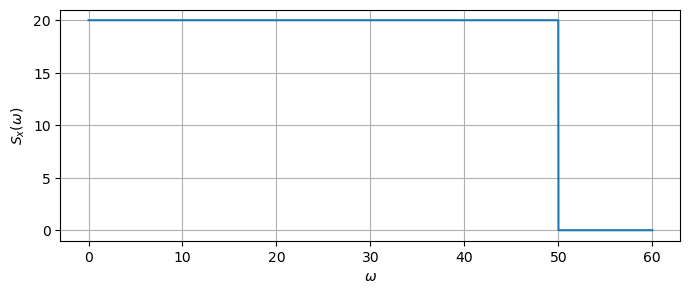

In [218]:
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append('./../../modules')
from time_integration import * # Import all functions in the module time_integration

omega_axis = np.arange(0.01,60,0.01) # Frequency axis

Sx=np.zeros_like(omega_axis)
Sx[(omega_axis>0) & (omega_axis<50)]=20

plt.figure(figsize=(8,3))
plt.plot(omega_axis,Sx)
plt.grid()
plt.ylabel(r'$S_x(\omega)$')
plt.xlabel(r'$\omega$')
#plt.yscale('log')


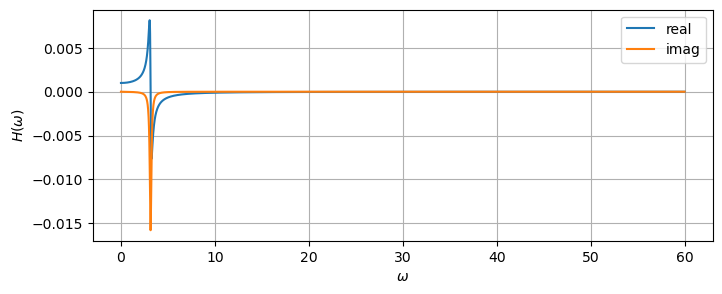

In [219]:
# Structural parameters
m=100
k=1000
c=20

# FRF
H=1/(-omega_axis**2*m+1j*omega_axis*c+k)

plt.figure(figsize=(8,3))
plt.plot(omega_axis,np.real(H),'-',label='real')
plt.plot(omega_axis,np.imag(H),'-',label='imag')
plt.grid()
plt.ylabel(r'$H(\omega)$')
plt.xlabel(r'$\omega$')
plt.legend()


Text(0.5, 0, '$\\omega$')

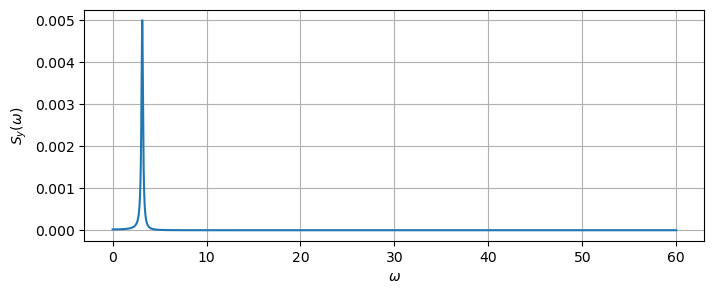

In [220]:
Sy=np.abs(H)**2*Sx

sd_y_fd=np.trapz(Sy,omega_axis)**0.5 # Standard deviation needed later

plt.figure(figsize=(8,3))
plt.plot(omega_axis,Sy)
plt.grid()
plt.ylabel(r'$S_y(\omega)$')
plt.xlabel(r'$\omega$')
#plt.yscale('log')

**b)**

The natural frequency is 10 rad/s, which has a natural period of 0.6 s. We set $\Delta t=0.02$ s.


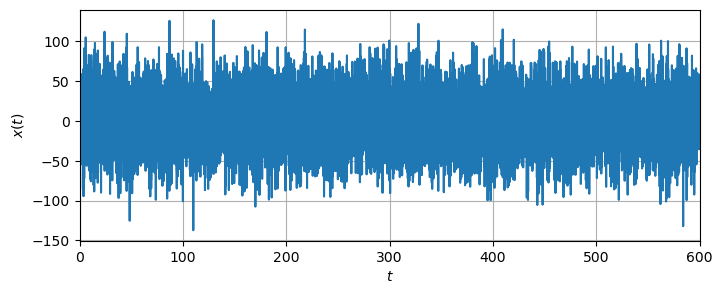

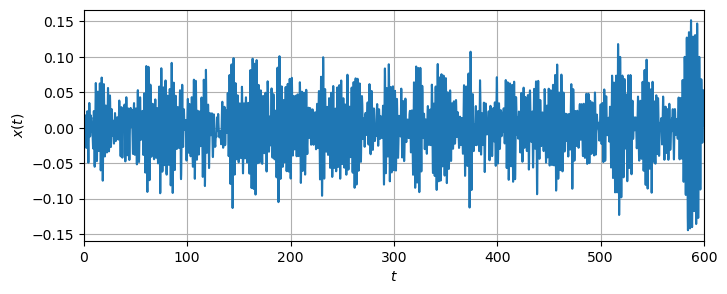

In [221]:

T=600
dt=0.02

N=int(T/dt)

t=np.arange(0,N,1)*dt # Time axis

domega=2*np.pi/T # Frequency spacing

omega_axis = np.arange(0,N,1)*domega # Frequency axis

Sx=np.zeros_like(omega_axis)
Sx[(omega_axis>0) & (omega_axis<50)]=20
Sx[0]=0

phi = np.random.rand(N)*2*np.pi # Random phase angles 
c_amp = (2*Sx*domega)**0.5*np.exp(1j*phi) # The complex amplitude including the phase angle
x = np.real(np.fft.ifft(c_amp)*N) # The IFFT

# Plot time series load
plt.figure(figsize=(8,3))
plt.plot(t,x)
plt.ylabel(r'$x(t)$')
plt.xlabel(r'$t$')
plt.xlim(0,600)
plt.grid()

y0 = np.array([0.0]) #Initial displacement
ydot0 = np.array([0.0]) # Initial velocity


# Solve by Newmark
y, ydot, y2dot = linear_newmark_krenk(m,c,k,x,y0,ydot0,dt)

# Plot time series response
plt.figure(figsize=(8,3))
plt.plot(t,y[0,:])
plt.ylabel(r'$x(t)$')
plt.xlabel(r'$t$')
plt.xlim(0,600)
plt.grid()



**c)**


In [222]:
sd_y_td=np.std(y[0,:])

print('Standard deviation of y is (time domain) ' + '{:.3e}'.format(sd_y_td))
print('Standard deviation of y is (frequency domain) ''{:.3e}'.format(sd_y_fd))

Standard deviation of y is (time domain) 3.934e-02
Standard deviation of y is (frequency domain) 3.963e-02


The standard deviation is the same, as expected. This means the variance can be directly calculated in the frequency domain as the area under the spectrum, and it is not neccessary to generate simulations of the load and then solve the response in order to obtain the response statistics.

### Problem 2: Spectral density of response in modal coordinates

The stiffness matrix $\mathbf{K}$ can be obtained by sequentially setting each DOF to a unity value, and then considering the forces in each DOF: 

$$
\mathbf{K}  = \begin{bmatrix}
2k_1 + 2k_2 & -2k_2 & 0 \\
-2k_2 & 2k_2 + 2k_3 & -2k_3 \\
0 & -2k_3 & 2k_3
\end{bmatrix}
$$

The mass matrix is diagonal since the floor masses are lumped into each DOF:

$$
\mathbf{M}  = \text{diag}(m_1, m_2, m_3)
$$

We start by calculating the modal properties.


In [223]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg as spla

# Define structural properties
m1=5.0
m2=4.0
m3=4.0

k1=1.5e3
k2=1.0e3
k3=1.0e3

K = np.array(([[2*k1+2*k2, -2*k2,0],
                [-2*k2, 2*k2+2*k3,-2*k3],
                [0, -2*k3,2*k3]])) # Stiffness matrix

M = np.diag([m1,m2,m3]) # Mass matrix
lam,v = spla.eig(K,M) #Solve eigenvalue problem using scipy 

mgen=v.T @ M @ v # Generalized masses (before normalization)

Phi=np.zeros_like(v)
for k in np.arange(3):
    Phi[:,k]=v[:,k]/np.sqrt(mgen[k,k]) # Mass normalize eigenvectors

omega_n = np.real(lam)**0.5 #Natural frequencies in rad/s

idx_sort=np.argsort(omega_n) # Find sorting order (smallest to biggest frequency)

omega_n=omega_n[idx_sort] # Rearrange frequencies
Phi=Phi[:,idx_sort] # Rearrange modes

print('Natural frequencies in rad/s:')
print(omega_n)

print('Mode shapes:')
print(Phi)


Natural frequencies in rad/s:
[10.87504704 28.35085542 39.72357422]
Mode shapes:
[[ 0.13155433  0.34157989  0.25693703]
 [ 0.2899896   0.1675697  -0.37124982]
 [ 0.37983267 -0.27581582  0.17219981]]


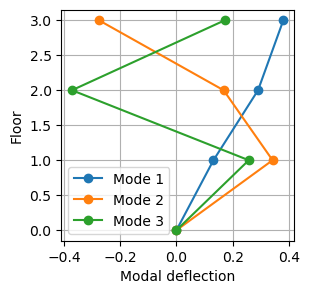

In [224]:
plt.figure(figsize=(3,3))

# Plot all 3 modes
for i in np.arange(3):

    phi_plot=np.append(0,Phi[:,i]) # Add zero to base of structure
    plt.plot(phi_plot,[0,1,2,3],marker='o',label='Mode ' + str(i+1))

plt.ylabel('Floor')
plt.xlabel('Modal deflection')
plt.legend()
plt.grid()


**b)**

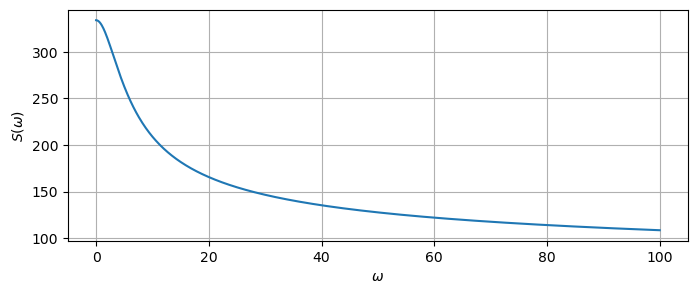

In [225]:
omega_axis=np.linspace(0,100,1000)

Sx=np.zeros((3,3,len(omega_axis)))
for k in np.arange(3):
    Sx[k,k,:]=1e3/np.log(omega_axis**2+20)
Sx[:,:,0]=0

plt.figure(figsize=(8,3))
plt.plot(omega_axis,1e3/np.log(omega_axis**2+20))
plt.grid()
plt.ylabel(r'$S(\omega)$')
plt.xlabel(r'$\omega$')

Sx_modal=np.zeros((3,3,len(omega_axis)))
for k in np.arange(len(omega_axis)):
    Sx_modal[:,:,k]=Phi.T @ Sx[:,:,k] @ Phi


From this plot, we can expect all modes to be excited (natural frequencies are 10.8, 28.3, and 39.7 rad/s), but the lower modes will probably have the largest contribution since there is more energy in the lower frequency range.

**c)**

The modal load is given by $
\mathbf{\tilde{x}}(t)
=
\mathbf{\Phi}^\text{T}
\mathbf{x}(t)
$.
Therefore, the spectrum of the modal load is: 
$$
\mathbf{S}_\mathbf{\tilde{x}}(\omega)
=\mathbf{\Phi}^\text{T}
\mathbf{S}_\mathbf{x}(\omega)
\mathbf{\Phi}
$$

See e.g. exercise 5, problem 2a) for a derivation.

The equation of motion is:
$$
\mathbf{M} \mathbf{\ddot{y}}(t)+\mathbf{C} \mathbf{\dot{z}}(t)+ \mathbf{K}  \mathbf{y}(t)= \mathbf{{x}}(t)
$$

After introducing 
$\mathbf{y}(t)
=
\mathbf{\Phi}
\mathbf{z}(t)
$ and premultiplying by $\mathbf{\Phi}^\text{T}$ we get:

$$
\mathbf{\ddot{z}}(t)+2  \cdot  \textbf{diag} (\xi)  \cdot  \textbf{diag} (\omega_n)  \cdot \mathbf{\dot{z}}(t)+ \textbf{diag} (\omega_n^2) \mathbf{z}(t)= \mathbf{\tilde{x}}(t)
$$

Here, the mode shapes are assumed to be mass-normalized.

**d)**

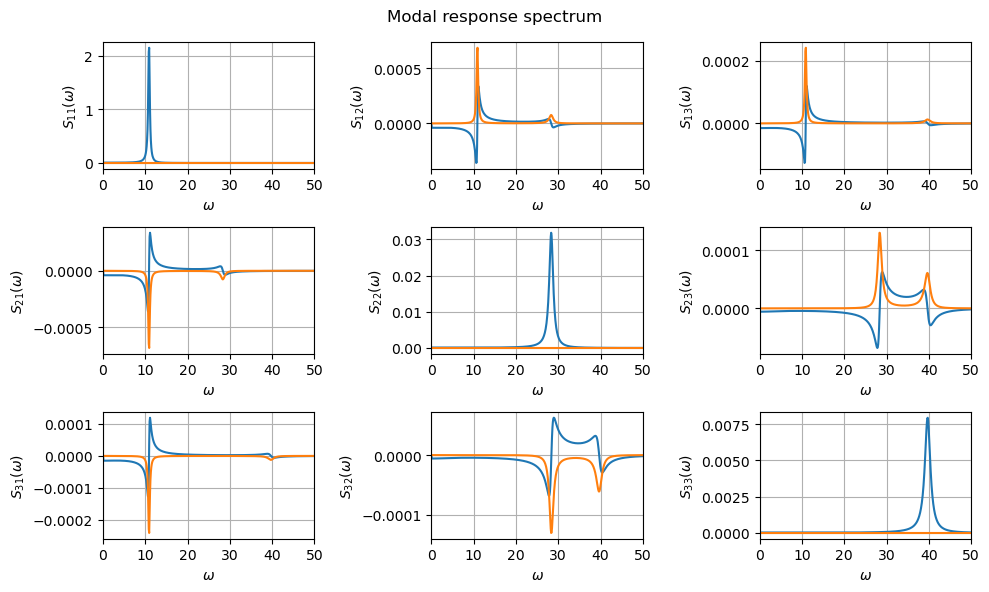

In [226]:
H_modal=np.zeros((3,3,len(omega_axis)),dtype=complex)
for k in np.arange(len(omega_axis)):
    tmp=-omega_axis[k]**2*np.eye(3)+1j*omega_axis[k]*2*np.diag(omega_n)*0.02+np.diag(omega_n)**2
    H_modal[:,:,k]=np.linalg.inv(tmp)

Sz=np.zeros((3,3,len(omega_axis)),dtype=complex)
for k in np.arange(len(omega_axis)):
    Sz[:,:,k]=H_modal[:,:,k] @ Sx_modal[:,:,k] @ np.conj(H_modal[:,:,k]).T

# Plot
fig, axs = plt.subplots(3, 3,figsize=(10, 6))

for i in np.arange(3):
    for j in np.arange(3):
        axs[i,j].plot(omega_axis,np.real(Sz[i,j,:]))
        axs[i,j].plot(omega_axis,np.imag(Sz[i,j,:]))        
        axs[i,j].set_xlabel(r'$\omega$')
        axs[i,j].set_ylabel(r'$S_{' + str(i+1) + str(j+1) + '} (\omega)$')
        axs[i,j].set_xlim(0,50)
        axs[i,j].grid(True)
        
fig.suptitle('Modal response spectrum')
plt.tight_layout()

The auto spectra only have one peak, at their respective natural frequencies. The cross-spectra between the modes have some small correlations.

**e)**

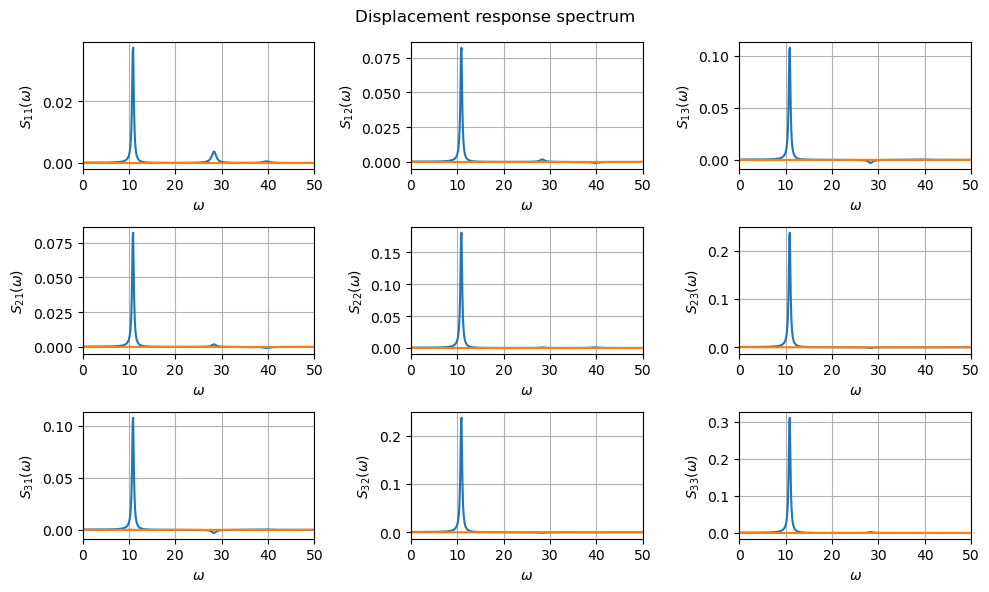

In [227]:
Sy=np.zeros((3,3,len(omega_axis)),dtype=complex)
for k in np.arange(len(omega_axis)):
    Sy[:,:,k]=Phi @ Sz[:,:,k] @ Phi.T

# Plot
fig, axs = plt.subplots(3, 3,figsize=(10, 6))

for i in np.arange(3):
    for j in np.arange(3):
        axs[i,j].plot(omega_axis,np.real(Sy[i,j,:]))
        axs[i,j].plot(omega_axis,np.imag(Sy[i,j,:]))
        axs[i,j].set_xlabel(r'$\omega$')
        axs[i,j].set_ylabel(r'$S_{' + str(i+1) + str(j+1) + '} (\omega)$')
        axs[i,j].set_xlim(0,50)
        axs[i,j].grid(True)
        
fig.suptitle('Displacement response spectrum')
plt.tight_layout()



The auto spectra now have multiple peaks, although mode 1 is the dominant contributor. Small contributions from mode 2 and 3 are visible for $y_1$.





**f)**

We can first calculate the covariance matrix for $\mathbf{y}$:

$$\mathbf{\Sigma_y}^2 = \left[ \begin{array}{c c c}
{\sigma _{y_1}^2}&{\rho _{y_1y_2}\sigma _{y_1}\sigma _{y_2}}& {\rho _{y_1y_3}\sigma _{y_1}\sigma _{y_3}}\\
{\rho _{y_2y_1}\sigma _{y_2}\sigma _{y_1}}&{\sigma _{y_2}^2}&{\rho _{y_2y_3}\sigma _{y_2}\sigma _{y_3}} \\
{\rho _{y_3y_1}\sigma _{y_3}\sigma _{y_1}}&{\rho _{y_3y_2}\sigma _{y_3} \sigma _{y_2}} & {\sigma _{y_2}^3}\\
\end{array} \right] $$

We find this as the area under the spectrum:

$$
\mathbf{\Sigma_y}^2
=
\int_{-\infty}^{\infty} 
\mathbf{S}_\mathbf{y}(\omega) \: \text{d} \omega
$$

Since we have a one-sided cross-spectral density matrix, the imaginary component of the cross-spectra will not cancel out. We therefore have to remember to take the real part only.

We can then find the correlation coefficients as:
$$
\rho_{y_i y_j} = \dfrac{\text{Cov}(y_i,y_j)}{ \sigma _{y_i} \sigma _{y_j}}
$$



In [228]:
Cy=np.real(np.trapz(Sy,omega_axis,axis=2))

rho_y=np.zeros_like(Cy)
for i in np.arange(3):
    for j in np.arange(3):
        rho_y[i,j]=Cy[i,j]/( np.sqrt(Cy[i,i]) * np.sqrt(Cy[j,j]) )


print(rho_y)

[[1.         0.88244043 0.8160425 ]
 [0.88244043 1.         0.94996407]
 [0.8160425  0.94996407 1.        ]]



The correlations are quite high (>0.8). If only one mode contributed to the response, the correlation would be 1 or -1 since all floors are moving perfectly in phase or out of phase with each other. Since there are small response contributions from 2 and 3 as well, the correlation becomes a bit lower.

**g)**

We can repeat the same calculation with a truncated version of $\mathbf{\Phi}$, or use the previous calculation results. We simply slice out the first mode (index 0) from $\mathbf{S}_\mathbf{z}$ and the first column of $\mathbf{\Phi}$.


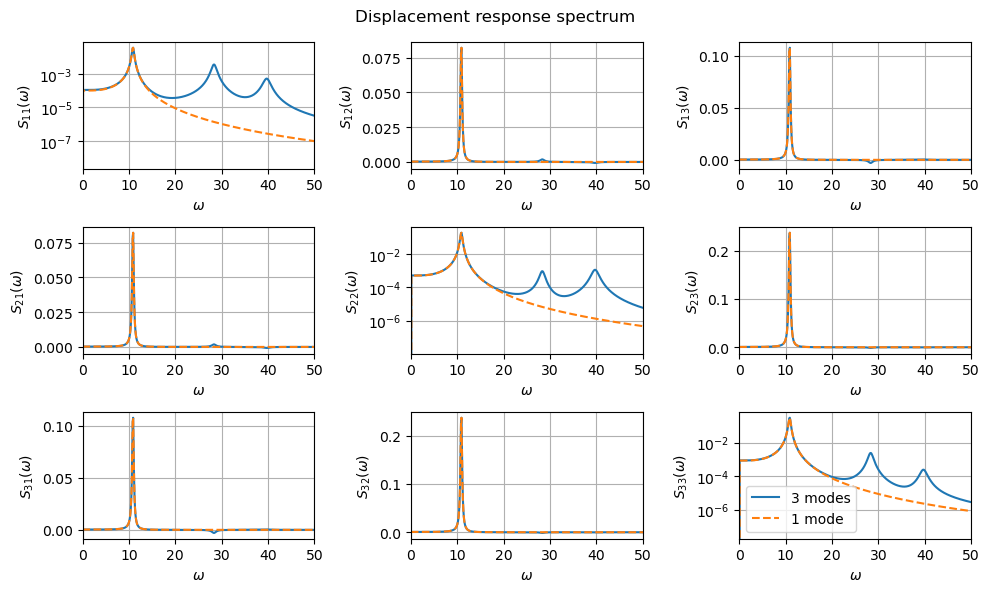

In [229]:
Sy_reduced=np.zeros((3,3,len(omega_axis)),dtype=complex)
for k in np.arange(len(omega_axis)):

    Phi_mode1=Phi[:, 0].reshape(-1, 1) # Ensure a column vector (Python will make the slice a 1d-vector)
    
    Sy_reduced[:,:,k]= Sz[0,0,k]*Phi_mode1@Phi_mode1.T

# Plot and compare with full
fig, axs = plt.subplots(3, 3,figsize=(10, 6))

for i in np.arange(3):
    for j in np.arange(3):
        axs[i,j].plot(omega_axis,Sy[i,j,:],label='3 modes')
        axs[i,j].plot(omega_axis,Sy_reduced[i,j,:],'--',label='1 mode')
        axs[i,j].set_xlabel(r'$\omega$')
        axs[i,j].set_ylabel(r'$S_{' + str(i+1) + str(j+1) + '} (\omega)$')
        axs[i,j].set_xlim(0,50)
        axs[i,j].grid(True)

        if i==j:
            axs[i,j].set_yscale('log')

fig.suptitle('Displacement response spectrum')
plt.tight_layout()
plt.legend()


We see that the calculation with one mode accounts for the first peak (and most of the variance of the spectrum), but it obviously neglects mode 2 and 3 (which are visible in log-scale).

A single-mode truncation of the system dynamics is a decent approximation in terms of variance (i.e., the area under the auto spectra).

**h)**

The acceleration response spectrum is derived from the displacement spectrum using the following relationship:

$$
\mathbf{S}_\mathbf{\ddot{y}}(\omega) = \omega^4 \mathbf{S}_\mathbf{y}(\omega)
$$

From the plot below, it is obvious that mode 2 and 3 contribute significantly to the accelerations, and a single mode truncation of the system dynamics is not a valid approximation.

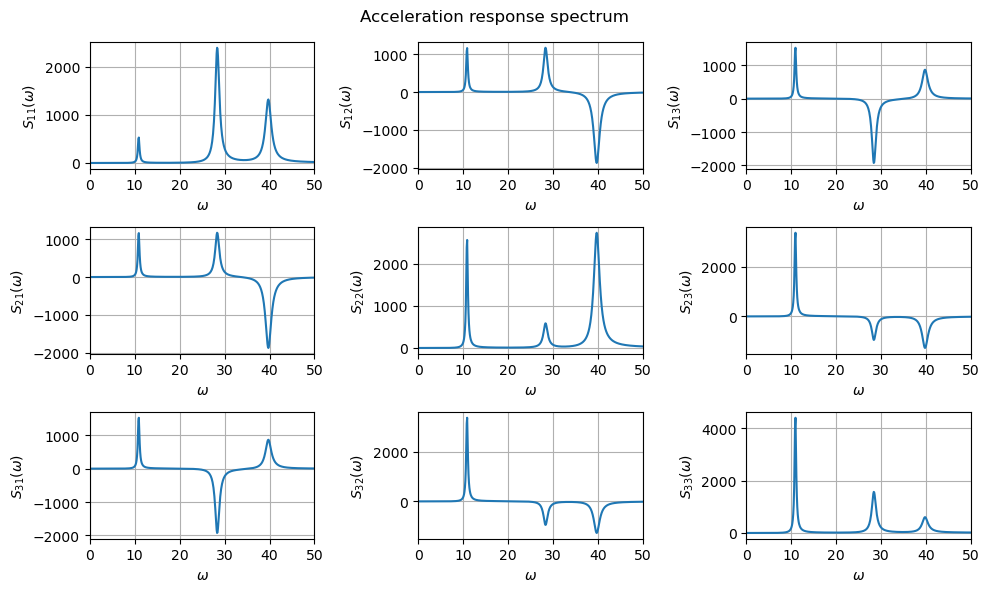

In [230]:

Syddot=np.zeros((3,3,len(omega_axis)),dtype=complex)
for k in np.arange(len(omega_axis)):
    Syddot[:,:,k]=omega_axis[k]**4 * Sy[:,:,k]

# Plot and compare with full
fig, axs = plt.subplots(3, 3,figsize=(10, 6))

for i in np.arange(3):
    for j in np.arange(3):
        axs[i,j].plot(omega_axis,Syddot[i,j,:])
        axs[i,j].set_xlabel(r'$\omega$')
        axs[i,j].set_ylabel(r'$S_{' + str(i+1) + str(j+1) + '} (\omega)$')
        axs[i,j].set_xlim(0,50)
        axs[i,j].grid(True)

        #if i==j:
            #axs[i,j].set_yscale('log')

fig.suptitle('Acceleration response spectrum')
plt.tight_layout()


### Problem 3: A tuned mass damper


**a)**

The equation of motion for the system **without** the TMD is defined as

$$m_1 \ddot{y} + c_1 \dot{y} + k_1 y = X1 $$

The equation of motion for the system **with** the TMD is defined as

$$ \left[ \begin{array} {c c}  m_1 & 0  \\ 0 & m_2 \end{array} \right]  \left[ \begin{array} {c}  \ddot{y}_1  \\ \ddot{y}_2 \end{array} \right]  +
 \left[ \begin{array} {c c}  c_1+c_2 & -c_2  \\ -c_2 & c_2 \end{array} \right]  \left[ \begin{array} {c}  \dot{y}_1  \\ \dot{y}_2 \end{array} \right] +
  \left[ \begin{array} {c c}  k_1+k_2 & -k_2  \\ -k_2 & k_2 \end{array} \right]  \left[ \begin{array} {c}  y_1  \\ y_2 \end{array} \right]+
 \left[ \begin{array} {c}  X_1  \\ 0 \end{array}\right]  $$



 **b**)

 

Standard deviation of response with TMD 1.358e-04
Standard deviation of response without TMD 4.509e-04


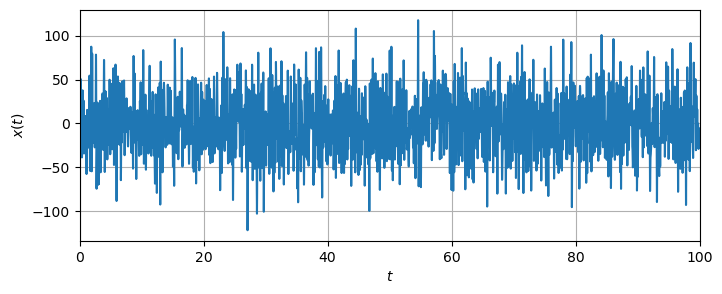

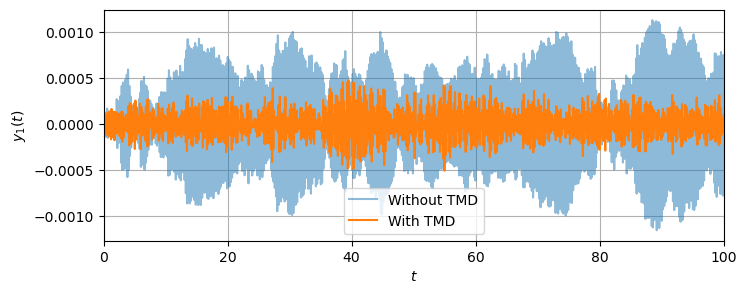

In [231]:

T=100
dt=0.01

N=int(T/dt)

t=np.arange(0,N,1)*dt # Time axis

domega=2*np.pi/T # Frequency spacing

omega_axis = np.arange(0,N,1)*domega # Frequency axis

# Load spectrum
Sx=np.zeros_like(omega_axis)
Sx[(omega_axis>0) & (omega_axis<50)]=20
Sx[0]=0

phi = np.random.rand(N)*2*np.pi # Random phase angles 
c_amp = (2*Sx*domega)**0.5*np.exp(1j*phi) # The complex amplitude including the phase angle
x = np.real(np.fft.ifft(c_amp)*N) # The IFFT

# Plot time series load
plt.figure(figsize=(8,3))
plt.plot(t,x)
plt.ylabel(r'$x(t)$')
plt.xlabel(r'$t$')
plt.xlim(0,100)
plt.grid()

f1 = 5
f2 = 4.9

xi1 = 0.5/100
xi2 = 5.0/100

m1 = 1000
m2 = 50

k1= (2*np.pi*f1)**2*m1
k2 = (2*np.pi*f2)**2*m2

c1 = 2*xi1*(np.pi*f1)*m1
c2 = 2*xi2*(np.pi*f2)*m2

M = np.array([[m1, 0],[0,m2]])
C = np.array([[c1+c2, -c2],[-c2,c2]])
K = np.array([[k1+k2, -k2],[-k2,k2]])

u0 = np.zeros((2,1))
udot0 = np.zeros((2,1))

X=np.vstack((x,x*0))

y_2dof, _, _ = linear_newmark_krenk(M,C,K,X,u0,udot0,dt)
y_1dof, _, _ = linear_newmark_krenk(m1,c1,k1,x,0,0,dt)

plt.figure(figsize=(8,3))
plt.plot(t,y_1dof[0,:],alpha=0.5,label="Without TMD")
plt.plot(t,y_2dof[0,:],label="With TMD")
plt.ylabel("$y_{1}(t)$")
plt.xlabel("$t$")
plt.xlim(0,100)
plt.legend()
plt.grid()

print('Standard deviation of response with TMD ' + '{:.3e}'.format(np.std(y_2dof[0,:])))
print('Standard deviation of response without TMD ' '{:.3e}'.format(np.std(y_1dof[0,:])))


The introduction of the TMD reduces the response in the system by a factor of $\sim 3$.

**c)**


Text(0.5, 0, '$\\omega$')

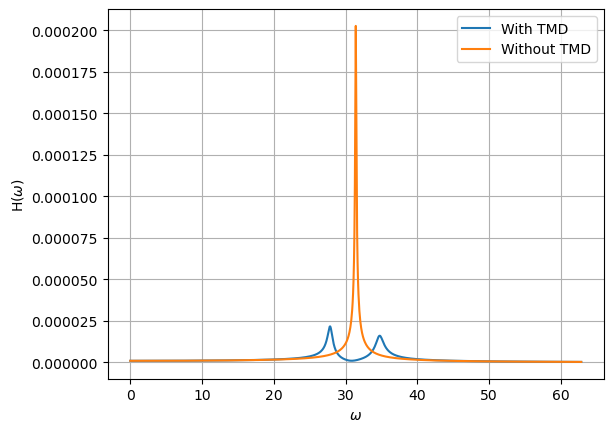

In [232]:

omega_axis = np.linspace(0,10*2*np.pi,1001)
H = np.zeros((2,2,len(omega_axis)),dtype="complex")
for k in range(len(omega_axis)):
    H[:,:,k] = np.linalg.inv(-omega_axis[k]**2*M + 1j*omega_axis[k]*C + K)

H_1dof = 1/(-omega_axis**2*m1 + 1j*omega_axis*c1 + k1) 
    
plt.figure(figsize=(8,3))
plt.plot(omega_axis,np.abs(H[0,0,:]),label="With TMD")
plt.plot(omega_axis,np.abs(H_1dof),label="Without TMD")
plt.grid()
plt.legend()
plt.ylabel("H($\omega$)")
plt.xlabel("$\omega$")
  

**d)**



Standard deviation of response with TMD (erroneous spring) 1.907e-04


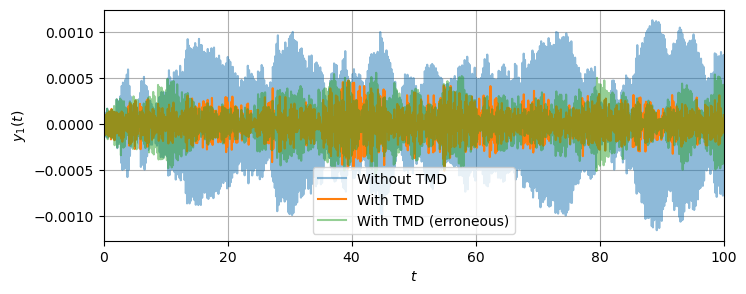

In [233]:

k2_erroneous = 0.7*(2*np.pi*f2)**2*m2 # Reduce k2 by 30%

K_erroneous = np.array([[k1+k2_erroneous, -k2_erroneous],[-k2_erroneous,k2_erroneous]]) # New stiffness matrix

y_2dof_erroneous, _, _ = linear_newmark_krenk(M,C,K_erroneous,X,u0,udot0,dt)

plt.figure(figsize=(8,3))
plt.plot(t,y_1dof[0,:],alpha=0.5,label="Without TMD")
plt.plot(t,y_2dof[0,:],label="With TMD")
plt.plot(t,y_2dof_erroneous[0,:],alpha=0.5,label="With TMD (erroneous)")
plt.ylabel("$y_{1}(t)$")
plt.xlabel("$t$")
plt.xlim(0,100)
plt.legend()
plt.grid()

print('Standard deviation of response with TMD (erroneous spring) ' + '{:.3e}'.format(np.std(y_2dof_erroneous[0,:])))


The response is now 50% larger than the case where the TMD has the correct spring stiffness.

**e)**


Text(0.5, 0, '$\\omega$')

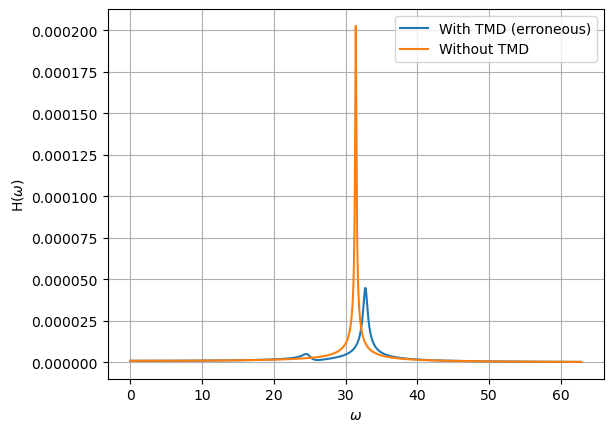

In [234]:
H_erroneous = np.zeros((2,2,len(omega_axis)),dtype="complex")
for k in range(len(omega_axis)):
    H_erroneous[:,:,k] = np.linalg.inv(-omega_axis[k]**2*M + 1j*omega_axis[k]*C + K_erroneous)
    
plt.figure(figsize=(8,3))
plt.plot(omega_axis,np.abs(H_erroneous[0,0,:]),label="With TMD (erroneous)")
plt.plot(omega_axis,np.abs(H_1dof),label="Without TMD")
plt.grid()
plt.legend()
plt.ylabel("H($\omega$)")
plt.xlabel("$\omega$")

**f)**

  

Standard deviation of response with TMD is 1.38e-04
Standard deviation of response without TMD is 4.50e-04


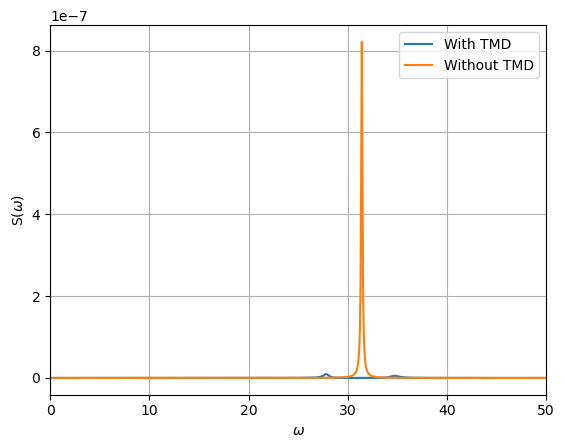

In [237]:
# Load spectrum (as a 2*2 matrix)
Sx=np.zeros((2,2,len(omega_axis)))
Sx[0,0,(omega_axis>0) & (omega_axis<50)]=20
Sx[:,:,0]=0

Sy = np.zeros((2,2,len(omega_axis)),dtype=complex)
for k in range(len(omega_axis)):
    Sy[:,:,k] = H[:,:,k] @ Sx[:,:,k] @ np.conj(H[:,:,k]).T

# 1 DOF system
Sy_1dof = np.abs(H_1dof)**2*Sx[0,0,:]

plt.figure(figsize=(8,3))
plt.plot(omega_axis,np.real(Sy[0,0,:]),label="With TMD")
plt.plot(omega_axis,np.real(Sy_1dof),label="Without TMD")
plt.ylabel("S($\omega$)")
plt.xlabel("$\omega$")
plt.grid()
plt.legend()
#plt.yscale('log')
plt.xlim(0,50)

sd_wTMD = np.real(np.trapz(Sy[0,0,:],omega_axis))**0.5
sd_woTMD = np.real(np.trapz(Sy_1dof,omega_axis))**0.5

print("Standard deviation of response with TMD is " + '{:.2e}'.format(sd_wTMD) )
print("Standard deviation of response without TMD is " + '{:.2e}'.format(sd_woTMD) )
